In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [93]:
class DM:
    def __init__(self, prior_alpha=None):
        if prior_alpha is None:
            self.alpha = np.ones(4)
            self.prev_alpha = np.ones(4)
        else:
            self.alpha = prior_alpha.copy()
            self.prev_alpha = prior_alpha.copy()
        
    def update(self, k):
        self.prev_alpha = self.alpha.copy()
        self.alpha[k] += 1
        
    def prob_obs(self, k=None, alpha=None):
        """ 
        Probability of observations given DM model 
        
        If k is None, return probability for all events
        If alpha is None, use self.alpha for computation
        """
        if alpha is None:
            alpha = self.alpha
            
        if k is None:
            return alpha / np.sum(alpha)
        return alpha[k] / np.sum(alpha)
    
    def surprise(self, k):
        """ Computde before update """
        return -np.log2(self.prob_obs(k))
    
    def predictability(self):
        """ Negative entropy, computed after update """
        p = self.prob_obs()
        return np.sum(p * np.log2(p))
    
    def learning_progress(self):
        """ 
        KL divergence between current and previous posterior,
        computed after update
        """
        p_before = self.prob_obs(alpha=self.prev_alpha)
        p_after  = self.prob_obs()
        
        return np.sum(p_after * np.log2(p_after / p_before))    

In [218]:
def simulate_ic(trial, prior_alpha=None):
    surprise = np.empty(len(trial))
    predictability = np.empty_like(surprise)
    lp = np.empty_like(surprise)

    dm = DM(prior_alpha)
    for i, event in enumerate(trial):
        surprise[i] = dm.surprise(event)
        dm.update(event)
        predictability[i] = dm.predictability()
        lp[i] = dm.learning_progress()
        
    return surprise, predictability, lp

In [219]:
def plot_ic(surprise, predictability, lp, ax=None, draw_assymptote=False, **kwargs):
    if ax is None:
        _, ax = plt.subplots(3, 1, figsize=(8, 6), sharex=True)
    
    x = np.arange(len(surprise)) + 1

    ax[0].plot(x, surprise, lw=2, color='C1', **kwargs)
    ax[0].set_ylabel('Surprise')

    ax[1].plot(x, predictability, lw=2, color='C2', **kwargs)
    ax[1].set_ylabel('Predictability')

    ax[2].plot(x, lp, lw=2, color='C0', **kwargs)
    ax[2].set_ylabel('Learning progress')

def plot_assymptotes(ax, conds=None):
    if conds is None:
        conds = ('60%-40%', '80%-20%', '100%-0%')
    
    surprise = {
        '60%-40%': (0.737, 2.907),
        '80%-20%': (0.322, 3.907),
        '100%-0%': (0, None),
    }
    
    predictability = {
        '60%-40%': -1.605,
        '80%-20%': -1.039,
        '100%-0%': 0,
    }
        
    alpha = .5
    ls = 'dotted'
    for i, axi in enumerate(ax):
        cond = conds[i]
        
        # Surprise
        for s in surprise[cond]:
            if s is not None:
                ax[0, i].axhline(s, color='k', ls=ls, alpha=alpha)

        ## Predictability
        p = predictability[cond]
        ax[1, i].axhline(p, color='k', ls=ls, alpha=alpha)

        # Learning progress
        ax[2, i].axhline(0, color='k', ls=ls, alpha=alpha),

# Paper example

In [220]:
# Example given in the paper
trial = np.array([0, 0, 2, 3, 0, 0, 3, 0, 1, 0, 0, 3])

In [221]:
surprise, predictability, lp = simulate_ic(trial)

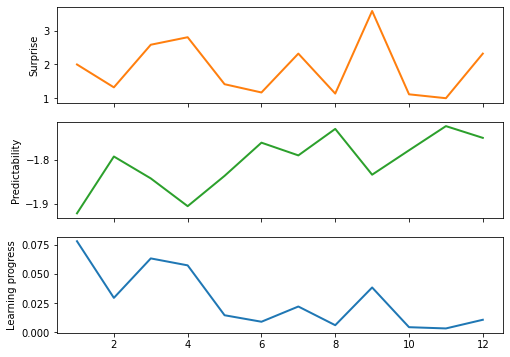

In [222]:
plot_ic(surprise, predictability, lp)

# Simulation

## Uniform prior

### Single trial

In [223]:
cond100 = np.array([0] * 15)
cond80 = np.array([0] * 12 + [1, 2, 3])
cond60 = np.array([0] * 9 + [1, 2, 3] * 2)

assert cond100.size == 15
assert cond80.size == 15
assert cond60.size == 15

assert np.mean(cond100 == 0) == 1
assert np.mean(cond80 == 0) == 0.8
assert np.mean(cond60 == 0) == 0.6

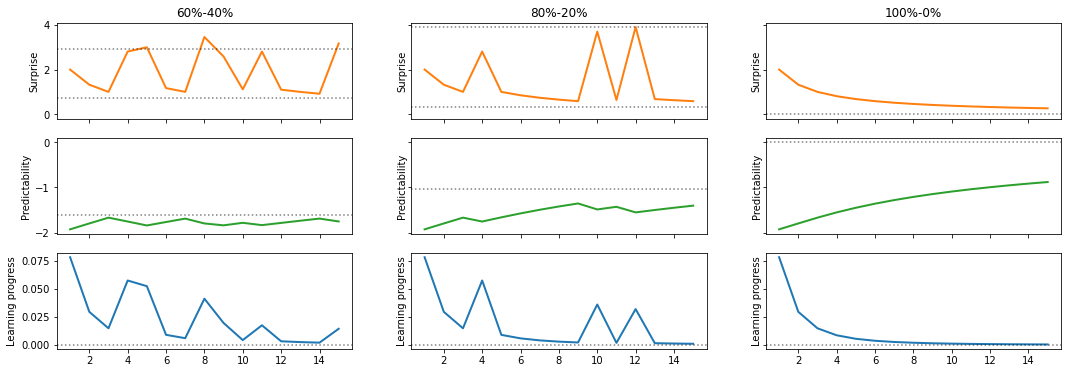

In [246]:
np.random.seed(0)
_, ax = plt.subplots(3, 3, figsize=(18, 6), sharex=True, sharey='row')

for i, (cond, cond_name) in enumerate(zip(
    (cond60, cond80, cond100),
    ('60%-40%', '80%-20%', '100%-0%'),
)):
    trial = cond.copy()
    np.random.shuffle(trial)
    surprise, predictability, lp = simulate_ic(trial)        
    plot_ic(surprise, predictability, lp, ax=ax[:, i])
    ax[0, i].set_title(cond_name)
    
plot_assymptotes(ax)

### Multiple trials

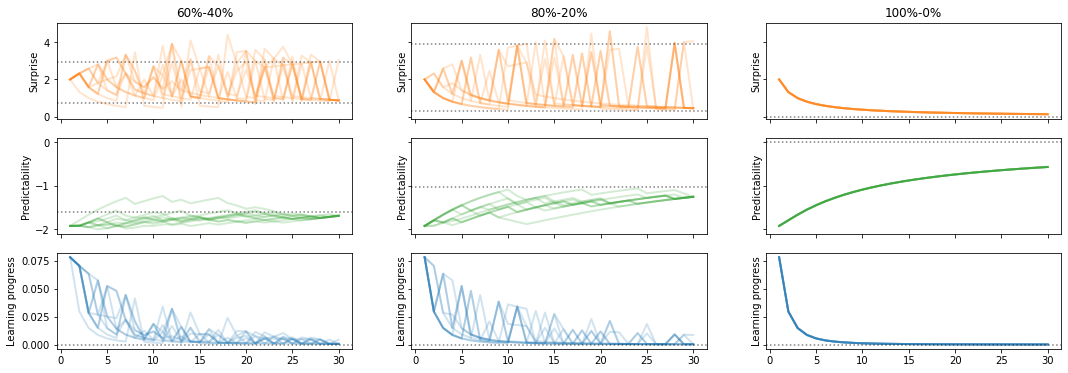

In [236]:
np.random.seed(0)
_, ax = plt.subplots(3, 3, figsize=(18, 6), sharex=True, sharey='row')

for _ in range(10):
    for i, cond in enumerate((cond60, cond80, cond100)):
        trial = np.repeat(cond.copy(), 2)
        np.random.shuffle(trial)
        surprise, predictability, lp = simulate_ic(trial)        
        plot_ic(surprise, predictability, lp, ax=ax[:, i], alpha=.2)        

ax[0, 0].set_title('60%-40%')
ax[0, 1].set_title('80%-20%')
ax[0, 2].set_title('100%-0%');
plot_assymptotes(ax)

## Sparse prior

### Single trial

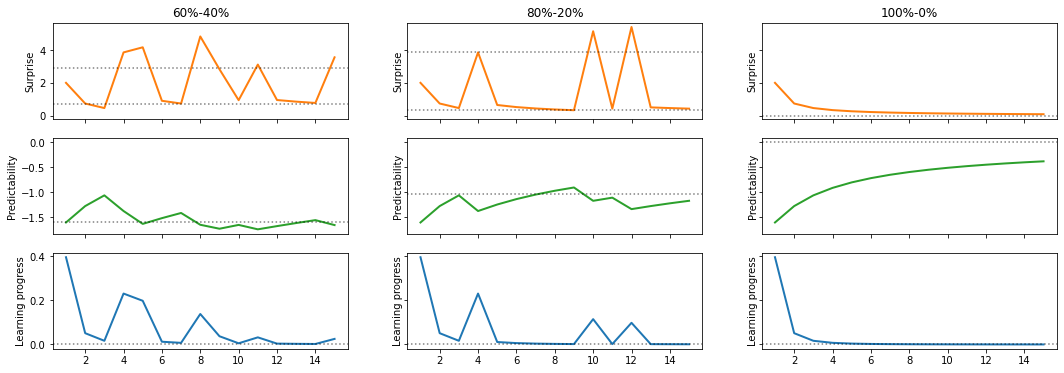

In [248]:
np.random.seed(0)
_, ax = plt.subplots(3, 3, figsize=(18, 6), sharex=True, sharey='row')

for i, cond in enumerate((cond60, cond80, cond100)):
    trial = cond.copy()
    np.random.shuffle(trial)
    surprise, predictability, lp = simulate_ic(trial, prior_alpha=np.ones(4)/3.5)        
    plot_ic(surprise, predictability, lp, ax=ax[:, i])

plot_assymptotes(ax)
    
ax[0, 0].set_title('60%-40%')
ax[0, 1].set_title('80%-20%')
ax[0, 2].set_title('100%-0%');

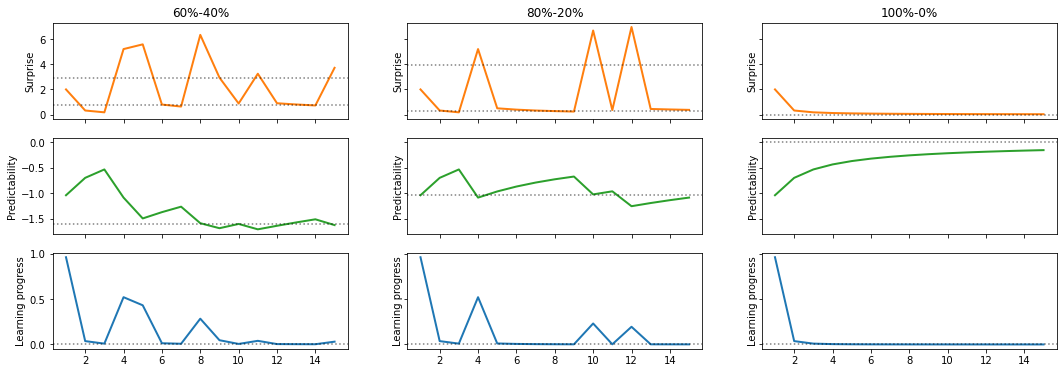

In [244]:
np.random.seed(0)
_, ax = plt.subplots(3, 3, figsize=(18, 6), sharex=True, sharey='row')

for i, cond in enumerate((cond60, cond80, cond100)):
    trial = cond.copy()
    np.random.shuffle(trial)
    surprise, predictability, lp = simulate_ic(trial, prior_alpha=np.ones(4)/11)        
    plot_ic(surprise, predictability, lp, ax=ax[:, i])

plot_assymptotes(ax)
    
ax[0, 0].set_title('60%-40%')
ax[0, 1].set_title('80%-20%')
ax[0, 2].set_title('100%-0%');

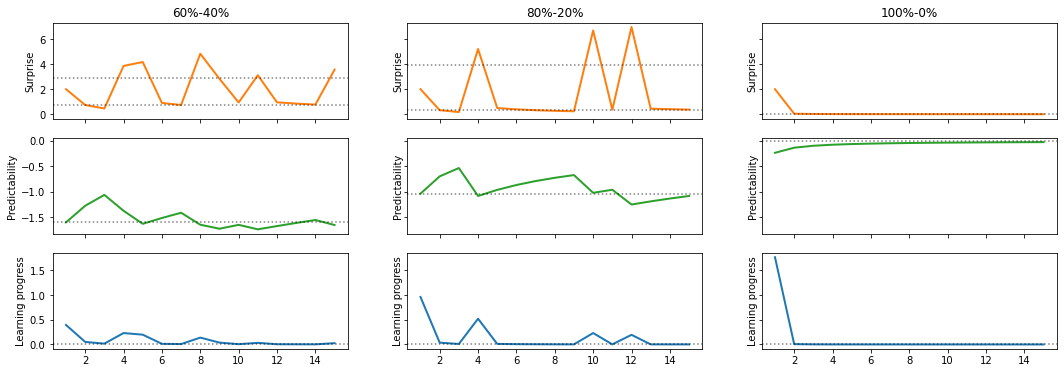

In [242]:
np.random.seed(0)
_, ax = plt.subplots(3, 3, figsize=(18, 6), sharex=True, sharey='row')

priors = (np.ones(4)/3.5, np.ones(4)/11, np.ones(4)/100)

for i, cond in enumerate((cond60, cond80, cond100)):
    trial = cond.copy()
    np.random.shuffle(trial)
    surprise, predictability, lp = simulate_ic(trial, prior_alpha=priors[i])        
    plot_ic(surprise, predictability, lp, ax=ax[:, i])

plot_assymptotes(ax)
    
ax[0, 0].set_title('60%-40%')
ax[0, 1].set_title('80%-20%')
ax[0, 2].set_title('100%-0%');

### Multiple trials

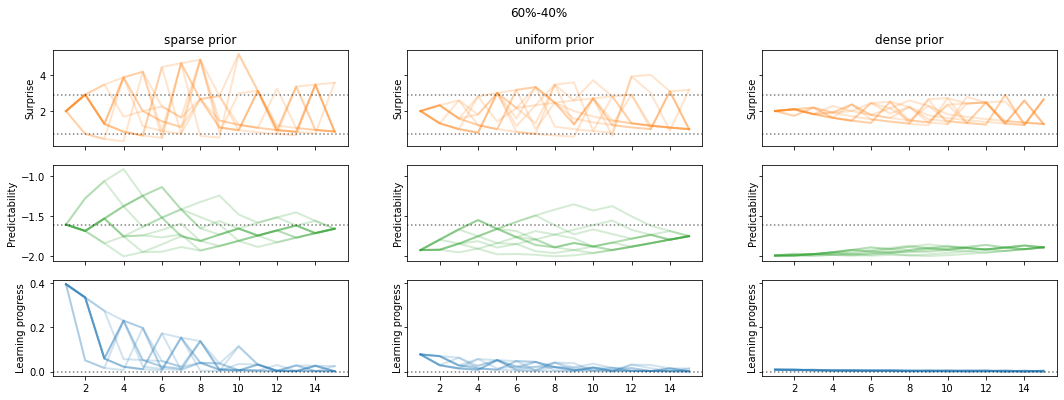

In [230]:
np.random.seed(0)
fig, ax = plt.subplots(3, 3, figsize=(18, 6), sharex=True, sharey='row')

cond = cond60
prior_sparse = np.ones(4) / 3.5
prior_uniform = np.ones(4)
prior_dense = np.ones(4) * 3.5
for _ in range(10):
    for i, prior in enumerate((prior_sparse, prior_uniform, prior_dense)):
        trial = np.repeat(cond.copy(), 1)
        np.random.shuffle(trial)
        surprise, predictability, lp = simulate_ic(trial, prior_alpha=prior)        
        plot_ic(surprise, predictability, lp, ax=ax[:, i], alpha=.2)
        
plot_assymptotes(ax, ['60%-40%']*3)
        
ax[0, 0].set_title('sparse prior')
ax[0, 1].set_title('uniform prior')
ax[0, 2].set_title('dense prior')
fig.suptitle('60%-40%');

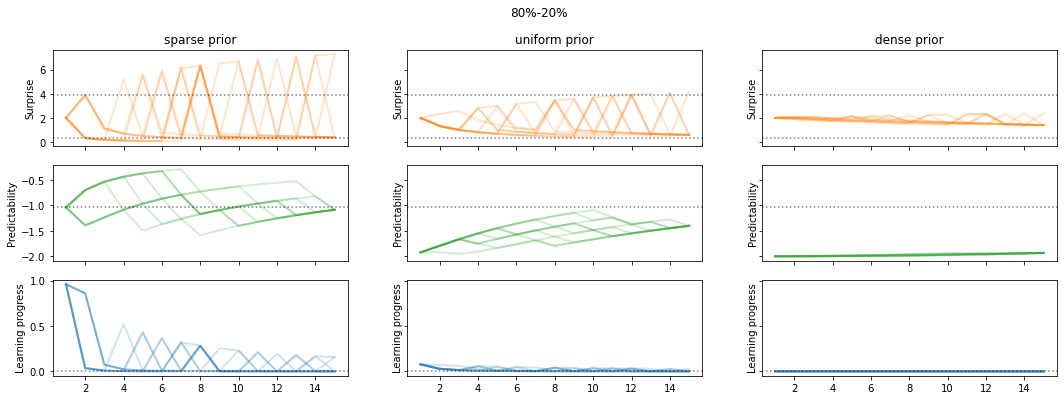

In [232]:
np.random.seed(0)
fig, ax = plt.subplots(3, 3, figsize=(18, 6), sharex=True, sharey='row')

cond = cond80
prior_sparse = np.ones(4) / 11
prior_uniform = np.ones(4)
prior_dense = np.ones(4) * 11
for _ in range(10):
    for i, prior in enumerate((prior_sparse, prior_uniform, prior_dense)):
        trial = np.repeat(cond.copy(), 1)
        np.random.shuffle(trial)
        surprise, predictability, lp = simulate_ic(trial, prior_alpha=prior)        
        plot_ic(surprise, predictability, lp, ax=ax[:, i], alpha=.2)

plot_assymptotes(ax, ['80%-20%']*3)
        
ax[0, 0].set_title('sparse prior')
ax[0, 1].set_title('uniform prior')
ax[0, 2].set_title('dense prior')
fig.suptitle('80%-20%');

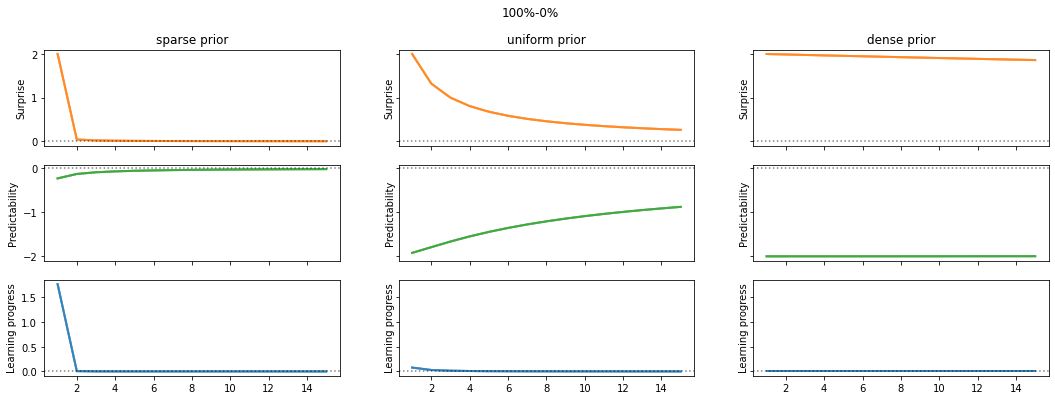

In [234]:
np.random.seed(0)
fig, ax = plt.subplots(3, 3, figsize=(18, 6), sharex=True, sharey='row')

cond = cond100
prior_sparse = np.ones(4) / 100
prior_uniform = np.ones(4)
prior_dense = np.ones(4) * 100
for _ in range(10):
    for i, prior in enumerate((prior_sparse, prior_uniform, prior_dense)):
        trial = np.repeat(cond.copy(), 1)
        np.random.shuffle(trial)
        surprise, predictability, lp = simulate_ic(trial, prior_alpha=prior)        
        plot_ic(surprise, predictability, lp, ax=ax[:, i], alpha=.2)

plot_assymptotes(ax, ['100%-0%']*3)
        
ax[0, 0].set_title('sparse prior')
ax[0, 1].set_title('uniform prior')
ax[0, 2].set_title('dense prior')
fig.suptitle('100%-0%');